In [1]:
import matplotlib.pyplot as plt
%matplotlib notebook
%pylab

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
from matplotlib.patches import FancyArrowPatch

class Arrow3D(FancyArrowPatch):
    # + on 25/07/2016

    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

def cum_var(evals0, silent=True, verbose=False):
    '''
    Determines the cumulative variance percentage from the eigenvalues
    Parameters
    ----------
    evals0 : array like
      First property (x-axis), x1, e.g., log(NII/Halpha)
    silent : boolean
          Turns off stdout messages. Default: True
    verbose : boolean
          Turns on additional stdout messages. Default: False
	  
    Returns
    -------
    cum_var0 : array like
      Array of cumulative variance normalized to 100%. Values are
      for PC_1, PC_2, ... PC_N
    Notes
    -----
    Created by Chun Ly, 25 July 2016
    '''

    tot      = sum(evals0)
    var0     = [(ii / tot)*100 for ii in sorted(evals0, reverse=True)]
    cum_var0 = np.cumsum(var0)

    return cum_var0
#enddef

def pca_str(evec, cum_var0=None, label_sample=None, silent=True, verbose=False):
    '''
    Construct string of PCA components to annotate plots
    Parameters
    ----------
    evec : array like
      First property (x-axis), x1, e.g., log(NII/Halpha)
    cum_var0 : array like, optional
      Array of cumulative variance normalized to 100%. Values are
      for PC_1, PC_2, ... PC_N
    
    label_sample : string, optional. Default: None
      Bibliographical label for points that are plotted
    silent : boolean, optional. Default: True
          Turns off stdout messages. 
    verbose : boolean, optional. Default: False
          Turns on additional stdout messages. 
	  
    Returns
    -------
    PCA_str : string
      Raw string returned. LaTeX-formatted
    Notes
    -----
    Created by Chun Ly, 25 July 2016
    '''

    n_vec = evec.shape[0]

    if n_vec == 2:
        PCA_str1 = r'PC$_1$ = %+5.3f$x_1$ %+5.3f$x_2$' % (evec[0][0], evec[0][1])
        PCA_str2 = r'PC$_2$ = %+5.3f$x_1$ %+5.3f$x_2$' % (evec[1][0], evec[1][1])
        if cum_var0 != None:
            PCA_str1 += (r'; $\sigma_{\rm cum}$ = %5.2f %%' % cum_var0[0])
        PCA_str  = PCA_str1+'\n'+PCA_str2
    
    if n_vec == 3:
        PCA_str1 = r'PC$_1$ = %+5.3f$x_1$ %+5.3f$x_2$ %+5.3f$x_3$' % (evec[0][0], evec[0][1],
                                                                      evec[0][2])
        PCA_str2 = r'PC$_2$ = %+5.3f$x_1$ %+5.3f$x_2$ %+5.3f$x_3$' % (evec[1][0], evec[1][1],
                                                                      evec[1][2])
        PCA_str3 = r'PC$_3$ = %+5.3f$x_1$ %+5.3f$x_2$ %+5.3f$x_3$' % (evec[2][0], evec[2][1],
                                                                      evec[2][2])
        if cum_var0 != None:
            PCA_str1 += (r'; $\sigma_{\rm cum}$ = %5.2f %%' % cum_var0[0])
            PCA_str2 += (r'; $\sigma_{\rm cum}$ = %5.2f %%' % cum_var0[1])

        PCA_str = PCA_str1+'\n'+PCA_str2+'\n'+PCA_str3

    # Mod on 02/08/2016
    if label_sample != None:
        PCA_str = " + ".join(label_sample)+'\n'+PCA_str

    return PCA_str
#enddef


In [3]:
import numpy as np, matplotlib.pyplot as plt
from astropy.io import ascii as asc

FULL_PATH = '/Users/kaitlynshin/GoogleDrive/NASA_Summer2015/'
CUTOFF_SIGMA = 4.0

# %matplotlib inline
# %matplotlib qt
# %matplotlib notebook

In [4]:
CUTOFF_MASS = 6.0

In [12]:
# reading in data generated by EBV_corrections.py
corr_tbl = asc.read(FULL_PATH+'Main_Sequence/mainseq_corrections_tbl.txt',guess=False,
                Reader=asc.FixedWidthTwoLine)
zspec0 = np.array(corr_tbl['zspec0'])
no_spectra  = np.where((zspec0 <= 0) | (zspec0 > 9))[0]
yes_spectra = np.where((zspec0 >= 0) & (zspec0 < 9))[0]

stlr_mass = np.array(corr_tbl['stlr_mass'])
filts = np.array(corr_tbl['filt'])
obs_sfr = np.array(corr_tbl['obs_sfr'])
dust_corr_factor = np.array(corr_tbl['dust_corr_factor'])
filt_corr_factor = np.array(corr_tbl['filt_corr_factor'])
nii_ha_corr_factor = np.array(corr_tbl['nii_ha_corr_factor'])


# defining useful data structs for plotting
filtarr = np.array(['NB704', 'NB711', 'NB816', 'NB921', 'NB973'])
markarr = np.array(['o', 'o', '^', 'D', '*'])

# defining an approximate redshift array for plot visualization
z_arr0 = np.array([7046.0, 7111.0, 8150.0, 9196.0, 9755.0])/6563.0 - 1
z_arr0 = np.around(z_arr0, 2)
z_arr  = np.array(z_arr0, dtype='|S4')
z_arr  = np.array([x+'0' if len(x)==3 else x for x in z_arr])

# # defining a flux sigma cutoff
# good_sig_iis = np.where(corr_tbl['flux_sigma'] >= CUTOFF_SIGMA)[0]
# defining a flux sigma + mass cutoff
good_sig_iis = np.where((corr_tbl['flux_sigma'] >= CUTOFF_SIGMA) & (corr_tbl['stlr_mass'] >= CUTOFF_MASS))[0]

# title = 'mainseq_filt_nii_dust_corrs'
corrs = filt_corr_factor+nii_ha_corr_factor+dust_corr_factor

xarr = stlr_mass[good_sig_iis]
yarr = obs_sfr[good_sig_iis]+corrs[good_sig_iis]
zarr = zspec0[good_sig_iis]

ffs = filts[good_sig_iis]

In [13]:
badz_iis = np.array([x for x in range(len(zarr)) if zarr[x] < 0 or zarr[x] > 9])
filt_lambda_list = {'NB704':7045.0, 'NB711':7126.0, 'NB816':8152.0, 'NB921':9193.0, 'NB973':9749.0}

In [14]:
for ff in filt_lambda_list.keys():
    badf_match = np.where(ffs[badz_iis] == ff)[0]
    zarr[badz_iis[badf_match]] = (filt_lambda_list[ff]/6562.8) - 1

In [15]:
labels = ['log[M]', 'z', 'SFR']

xData = np.copy(xarr)
yData = np.copy(zarr)
zData = np.copy(yarr)

n_sample = len(xData)

In [16]:
xData0 = np.reshape(xData, (len(xData),1))
yData0 = np.reshape(yData, (len(yData),1))
zData0 = np.reshape(zData, (len(zData),1))

In [17]:
data = np.hstack((xData0, yData0, zData0))
print data

[[ 7.73        0.0724     -1.60271705]
 [ 6.71        0.0682     -2.10619367]
 [ 8.24        0.401      -1.09863694]
 ..., 
 [ 9.17        0.485494   -0.68886524]
 [ 8.94        0.485494   -0.20851904]
 [ 8.35        0.485494   -0.80122209]]


In [18]:
mu = data.mean(axis=0)
print '## mean : ', mu

## mean :  [ 8.19675225  0.34151687 -1.16008038]


In [19]:
data = data - mu
evec, eval0, V = np.linalg.svd(data.T, full_matrices=False)
cum_var0 = cum_var(eval0) # + on 25/07/2016
projected_data0 = np.dot(data, evec)
sigma = projected_data0.std(axis=0).mean()

In [20]:
print data

[[-0.46675225 -0.26911687 -0.44263667]
 [-1.48675225 -0.27331687 -0.94611328]
 [ 0.04324775  0.05948313  0.06144345]
 ..., 
 [ 0.97324775  0.14397712  0.47121514]
 [ 0.74324775  0.14397712  0.95156135]
 [ 0.15324775  0.14397712  0.35885829]]


In [21]:
# for ii in range(n_sample):
#     x1 = np.reshape(xData[ii], (len(xData[ii]),1))
#     y1 = np.reshape(yData[ii], (len(yData[ii]),1))
#     z1 = np.reshape(zData[ii], (len(zData[ii]),1))
#     t_data = np.hstack((x1,y1,z1))
#     temp  = np.dot(t_data, evec)
#     if ii == 0:
#         projected_data = [temp]
#     else: projected_data.append(temp)

In [22]:
# plot_3d(xData, yData, zData, evec, mu, sigma, labels, out_pdf='temp_out.pdf',
#         ref_name0=None, cum_var0=cum_var0, silent=False,
#         verbose=True, animate=False, label_sample=None,
#         proposal=False)

In [23]:
evec

array([[-0.70563764,  0.70840266, -0.01553047],
       [-0.08481826, -0.10620698, -0.99071991],
       [-0.70347806, -0.69777199,  0.13502912]])

In [24]:
cum_var0

array([  74.90262103,   95.26679023,  100.        ])

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:88: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


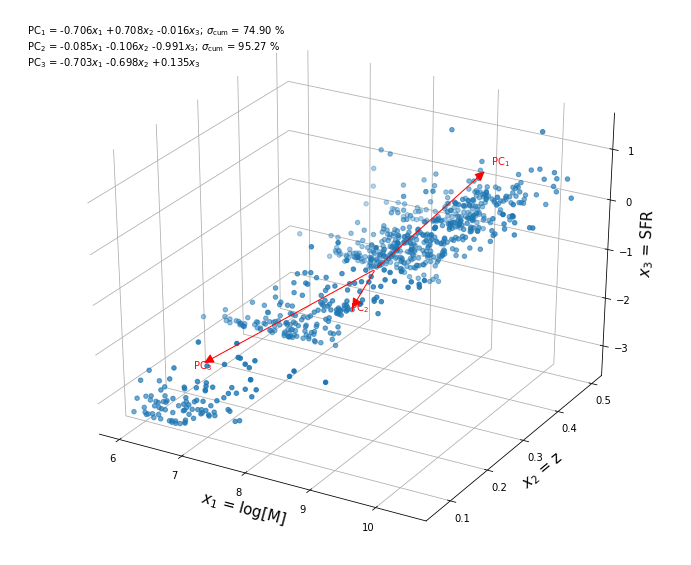

In [25]:
from mpl_toolkits.mplot3d import Axes3D, proj3d

fig = plt.figure()
fig.set_size_inches(12,10)
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xData, yData, zData)
ax.set_xlabel(r'$x_1$ = '+labels[0], fontsize='15')
ax.set_ylabel(r'$x_2$ = '+labels[1], fontsize='15')
ax.set_zlabel(r'$x_3$ = '+labels[2], fontsize='15')
PCA_str = pca_str(evec, cum_var0=cum_var0)

for ii in range(evec.shape[0]):
    axis = evec[ii]

    xd = [mu[0], mu[0] + sigma * axis[0]]
    yd = [mu[1], mu[1] + sigma * axis[1]]
    zd = [mu[2], mu[2] + sigma * axis[2]]

    a = Arrow3D(xd, yd, zd, mutation_scale=20, lw=1, arrowstyle="-|>",
                color="r")
    ax.add_artist(a)

    xt = mu[0] + 1.05 * sigma * axis[0]
    yt = mu[1] + 1.05 * sigma * axis[1]
    zt = mu[2] + 1.05 * sigma * axis[2]
    ax.text(xt, yt, zt, r'PC$_'+str(ii+1)+'$', color='red')

ax.annotate(PCA_str, (0.025,0.975), xycoords='axes fraction',
                ha='left', va='top')


for axis in [ax.w_xaxis, ax.w_yaxis, ax.w_zaxis]:
    axis.gridlines.set_linestyle('dashed')
    axis.set_pane_color((1,1,1,1)) # White background
    axis.gridlines.set_color((0,0,0,1)) # Black grid

In [26]:
%matplotlib inline

## mean :  [ 8.19675225 -1.16008038]
[[-0.70867199 -0.7055381 ]
 [-0.7055381   0.70867199]]
[  78.65452505  100.        ]


/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:77: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


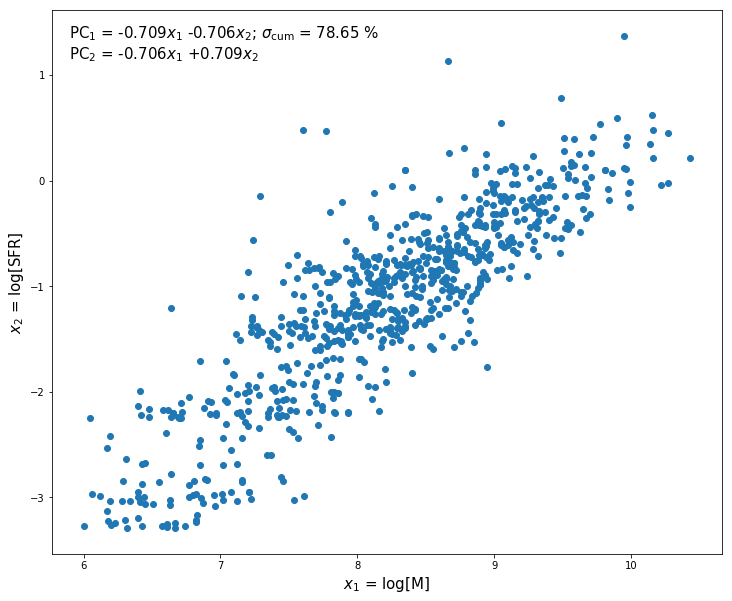

In [27]:
n_sample = len(xarr)
labels = ['log[M]', 'log[SFR]']

xData = np.copy(xarr) # log[M]
zData = np.copy(yarr) # log[SFR]

xData0 = np.reshape(xData, (len(xData),1))
zData0 = np.reshape(zData, (len(zData),1))

data = np.hstack((xData0, zData0))
mu = data.mean(axis=0)
print '## mean : ', mu
data = data - mu
evec, eval0, V = np.linalg.svd(data.T, full_matrices=False)
cum_var0 = cum_var(eval0) # + on 25/07/2016
projected_data0 = np.dot(data, evec)
sigma = projected_data0.std(axis=0).mean()

print evec
print cum_var0

# fig, ax = plt.figure()
# fig.set_size_inches(12,10)

plt.scatter(xData, zData)
plt.xlabel(r'$x_1$ = '+labels[0], fontsize='15')
plt.ylabel(r'$x_2$ = '+labels[1], fontsize='15')
PCA_str = pca_str(evec, cum_var0=cum_var0)

for ii in range(evec.shape[0]):
    axis = evec[ii]

    xd = [mu[0], mu[0] + sigma * axis[0]]
    yd = [mu[1], mu[1] + sigma * axis[1]]
#     zd = [mu[2], mu[2] + sigma * axis[2]]

#     a = Arrow3D(xd, yd, mutation_scale=20, lw=1, arrowstyle="-|>",
#                 color="r")

#     a = Arrow3D(xd, yd, zd, mutation_scale=20, lw=1, arrowstyle="-|>",
#                 color="r")
#     ax.add_artist(a)

    xt = mu[0] + 1.05 * sigma * axis[0]
    yt = mu[1] + 1.05 * sigma * axis[1]
#     zt = mu[2] + 1.05 * sigma * axis[2]
#     ax.text(xt, yt, zt, r'PC$_'+str(ii+1)+'$', color='red')

plt.annotate(PCA_str, (0.025,0.975), xycoords='axes fraction',
                ha='left', va='top', fontsize=15)

plt.gcf().set_size_inches(12,10)

In [28]:
# def pca_2d_fit(m):
#     return 0.673/0.739*m

# plt.plot(smass0, sfrs00, 'o')
# plt.plot(smass0, pca_2d_fit(smass0))

In [29]:
# compute median of galaxies in PCA space to get intercept

In [30]:
fout  = asc.read(FULL_PATH+'FAST/outputs/NB_IA_emitters_allphot.emagcorr.ACpsf_fast.GALEX.fout',
                 guess=False,Reader=asc.NoHeader)
stlr_mass = np.array(fout['col7'])

In [31]:
len(np.where(stlr_mass==-1.0)[0])

211

In [32]:
import scipy.optimize as optimize
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import ascii as asc

FULL_PATH = '/Users/kaitlynshin/GoogleDrive/NASA_Summer2015/'
CUTOFF_SIGMA = 4.0

In [54]:
corr_tbl = asc.read(FULL_PATH+'Main_Sequence/mainseq_corrections_tbl.txt',guess=False,
                Reader=asc.FixedWidthTwoLine)
zspec0 = np.array(corr_tbl['zspec0'])

fout  = asc.read(FULL_PATH+'FAST/outputs/NB_IA_emitters_allphot.emagcorr.ACpsf_fast.GALEX.fout',
                 guess=False,Reader=asc.NoHeader)
stlr_mass = np.array(fout['col7'])

filts = np.array(corr_tbl['filt'])

# # defining a flux sigma cutoff
# good_sig_iis = np.where(corr_tbl['flux_sigma'] >= CUTOFF_SIGMA)[0]
# defining a flux sigma + mass cutoff
good_sig_iis = np.where((corr_tbl['flux_sigma'] >= CUTOFF_SIGMA) & (corr_tbl['stlr_mass'] >= CUTOFF_MASS))[0]

obs_sfr = np.array(corr_tbl['obs_sfr'])
dust_corr_factor = np.array(corr_tbl['dust_corr_factor'])
filt_corr_factor = np.array(corr_tbl['filt_corr_factor'])
nii_ha_corr_factor = np.array(corr_tbl['nii_ha_corr_factor'])
corrs = filt_corr_factor+nii_ha_corr_factor+dust_corr_factor

ffs = filts[good_sig_iis]

zspec0 = np.array(corr_tbl['zspec0'])[good_sig_iis]
smass0 = stlr_mass[corr_tbl['ID'].data-1][good_sig_iis]

badz_iis = np.array([x for x in range(len(zspec0)) if zspec0[x] < 0 or zspec0[x] > 9])
filt_lambda_list = {'NB704':7045.0, 'NB711':7126.0, 'NB816':8152.0, 'NB921':9193.0, 'NB973':9749.0}

for ff in filt_lambda_list.keys():
    badf_match = np.where(ffs[badz_iis] == ff)[0]
    zspec0[badz_iis[badf_match]] = (filt_lambda_list[ff]/6562.8) - 1
    
sfrs00 = obs_sfr[good_sig_iis]+corrs[good_sig_iis]

In [55]:
data00 = np.vstack([smass0, zspec0]).T

In [56]:
zspec0

array([ 0.0724    ,  0.0682    ,  0.401     ,  0.07347474,  0.4003    ,
        0.07347474,  0.07347474,  0.4001    ,  0.07347474,  0.401     ,
        0.4081    ,  0.0681    ,  0.3992    ,  0.4084    ,  0.4076    ,
        0.40077406,  0.4012    ,  0.4006    ,  0.40077406,  0.4014    ,
        0.3998    ,  0.4081    ,  0.4012    ,  0.4006    ,  0.4       ,
        0.3919    ,  0.4009    ,  0.0781    ,  0.40077406,  0.3934    ,
        0.07347474,  0.07347474,  0.3934    ,  0.0701    ,  0.3992    ,
        0.407     ,  0.408     ,  0.0731    ,  0.397     ,  0.4126    ,
        0.07347474,  0.3918    ,  0.3995    ,  0.3938    ,  0.4052    ,
        0.4015    ,  0.4006    ,  0.4015    ,  0.4017    ,  0.4004    ,
        0.07347474,  0.3989    ,  0.40077406,  0.4003    ,  0.3997    ,
        0.07347474,  0.3993    ,  0.0728    ,  0.399     ,  0.07347474,
        0.07347474,  0.0733    ,  0.07347474,  0.07347474,  0.07347474,
        0.4003    ,  0.399     ,  0.4003    ,  0.4011    ,  0.06

In [57]:
"""
data[:,0] = log[M]
data[:,1] = redshift

Usage:
params, pcov = optimize.curve_fit(func, A[:,:2], A[:,2], guess)
o The first argument to curve_fit is the function.
o The second argument is the independent data (x and y in the form of one array).
o The third argument is the dependent data (z).
o The fourth argument is a guess for the value of the parameters (a and b in this case.)
"""
eqn0 = r'$log[SFR] = a*log[M] + b*z + c$'
def func0(data, a, b, c):
    return a*data[:,0] + b*data[:,1] + c

# eqn1 = r'$log[SFR] = a*log[M] + b*(1+z) + c$'
# def func1(data, a, b, c):
#     return a*data[:,0] + b*(1+data[:,1]) + c
eqn1 = r'$log[SFR] = a*log[M] + b*z^2 + c*z + d$'
def func1(data, a, b, c, d):
    return a*data[:,0] + b*(data[:,1])**2 + c*data[:,1] + d

eqn2 = r'$log[SFR] = a*log[M] + (z)^{b} + c$'
def func2(data, a, b, c):
    return a*data[:,0] + (data[:,1])**b + c

eqn3 = r'$log[SFR] = a*log[M] + (1+z)^{b} + c$'
def func3(data, a, b, c):
    return a*data[:,0] + (1+data[:,1])**b + c

eqn4 = r'$log[SFR] = a*log[M] + b*\log(1+z) + c$'
def func4(data, a, b, c):
    return a*data[:,0] + np.log10(1+data[:,1]) + c

eqn5 = r'$log[SFR] = a*log[M] + b$'
def line(x, m, b):
    return m*x + b

## method='lm'

$log[SFR] = a*log[M] + b*z + c$
$log[SFR] = a*log[M] + b*z^2 + c*z + d$
$log[SFR] = a*log[M] + (z)^{b} + c$
$log[SFR] = a*log[M] + (1+z)^{b} + c$
$log[SFR] = a*log[M] + b*\log(1+z) + c$
$log[SFR] = a*log[M] + b$


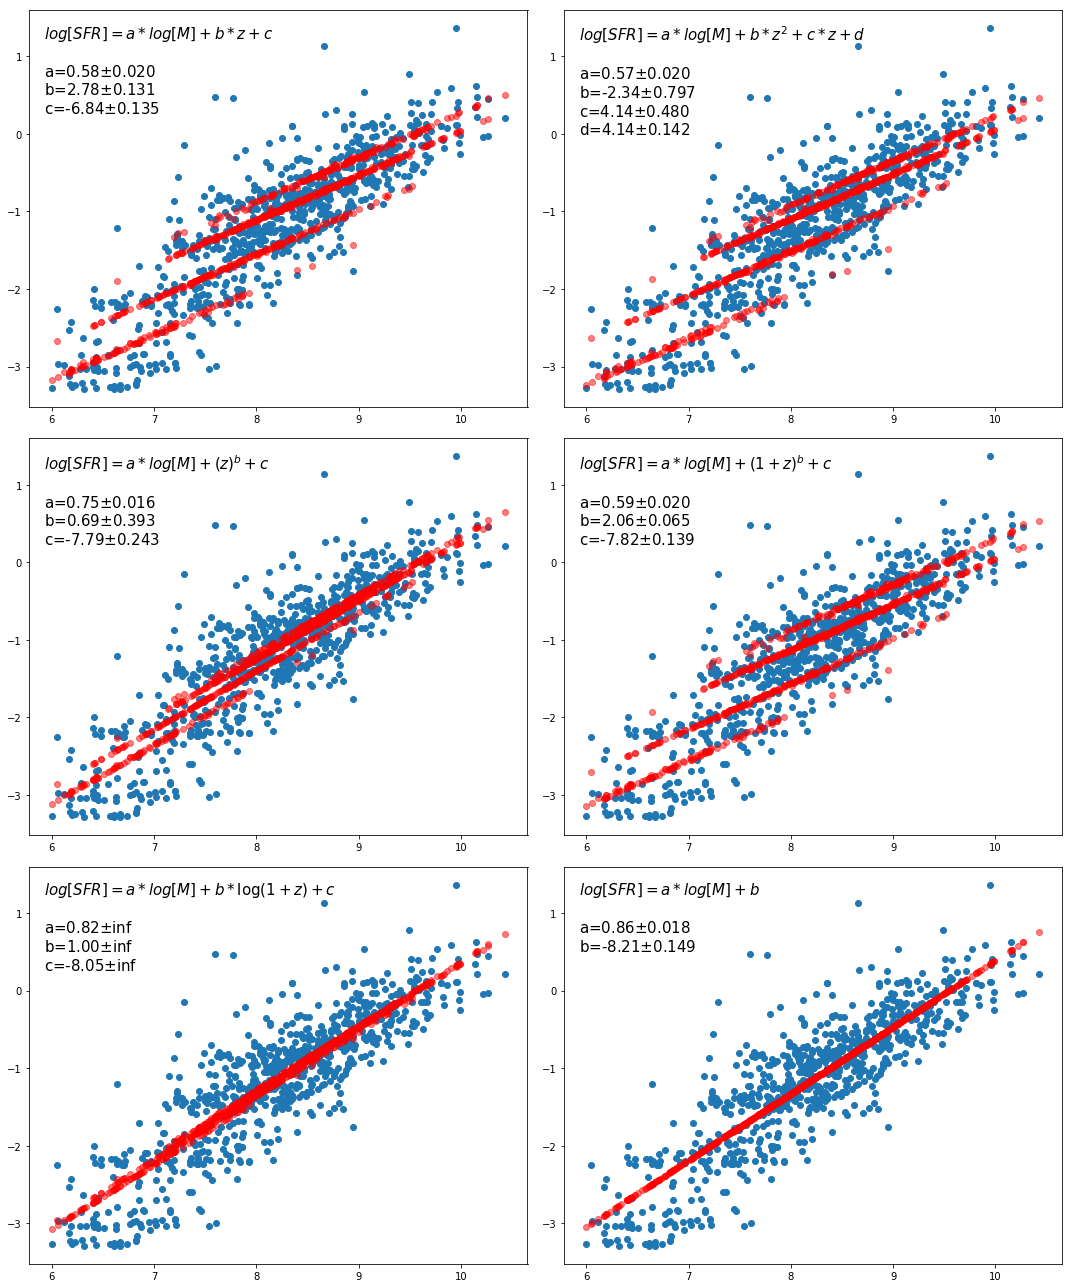

In [58]:
f, axes = plt.subplots(3,2)
axarr = np.ndarray.flatten(axes)

guess = (0.8,1, -7)
for ax, func, eqn_str in zip(axarr, [func0, func1, func2, func3, func4, line], 
                             [eqn0, eqn1, eqn2, eqn3, eqn4, eqn5]):
    ax.plot(smass0, sfrs00, 'o')
    print eqn_str
    
    if 'c' in eqn_str and 'd' not in eqn_str:   
        params, pcov = optimize.curve_fit(func, data00, sfrs00, guess, method='lm')
        perr = np.sqrt(np.diag(pcov))
        ax.plot(smass0, func(data00, *params), 'ro', alpha=0.5)
        ax.text(0.03,0.97,eqn_str+
            '\n\na='+'{:.2f}'.format(params[0])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[0])+
            '\nb='+'{:.2f}'.format(params[1])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[1])+
            '\nc='+'{:.2f}'.format(params[2])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[2]),
            transform=ax.transAxes,fontsize=15,ha='left',va='top')
    elif 'd' in eqn_str:
        params, pcov = optimize.curve_fit(func, data00, sfrs00, method='lm')
        perr = np.sqrt(np.diag(pcov))
        ax.plot(smass0, func(data00, *params), 'ro', alpha=0.5)
        ax.text(0.03,0.97,eqn_str+
            '\n\na='+'{:.2f}'.format(params[0])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[0])+
            '\nb='+'{:.2f}'.format(params[1])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[1])+
            '\nc='+'{:.2f}'.format(params[2])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[2])+
            '\nd='+'{:.2f}'.format(params[2])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[3]),
            transform=ax.transAxes,fontsize=15,ha='left',va='top')
    else:
        params, pcov = optimize.curve_fit(func, smass0, sfrs00, method='lm')
        perr = np.sqrt(np.diag(pcov))
        ax.plot(smass0, func(smass0, *params), 'ro', alpha=0.5)
        ax.text(0.03,0.97,eqn_str+
            '\n\na='+'{:.2f}'.format(params[0])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[0])+
            '\nb='+'{:.2f}'.format(params[1])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[1]),
            transform=ax.transAxes,fontsize=15,ha='left',va='top')
    

f.set_size_inches(15,18)
f.tight_layout()

## method='trf'

$log[SFR] = a*log[M] + b*z + c$
$log[SFR] = a*log[M] + b*z^2 + c*z + d$
$log[SFR] = a*log[M] + (z)^{b} + c$
$log[SFR] = a*log[M] + (1+z)^{b} + c$
$log[SFR] = a*log[M] + b*\log(1+z) + c$
$log[SFR] = a*log[M] + b$


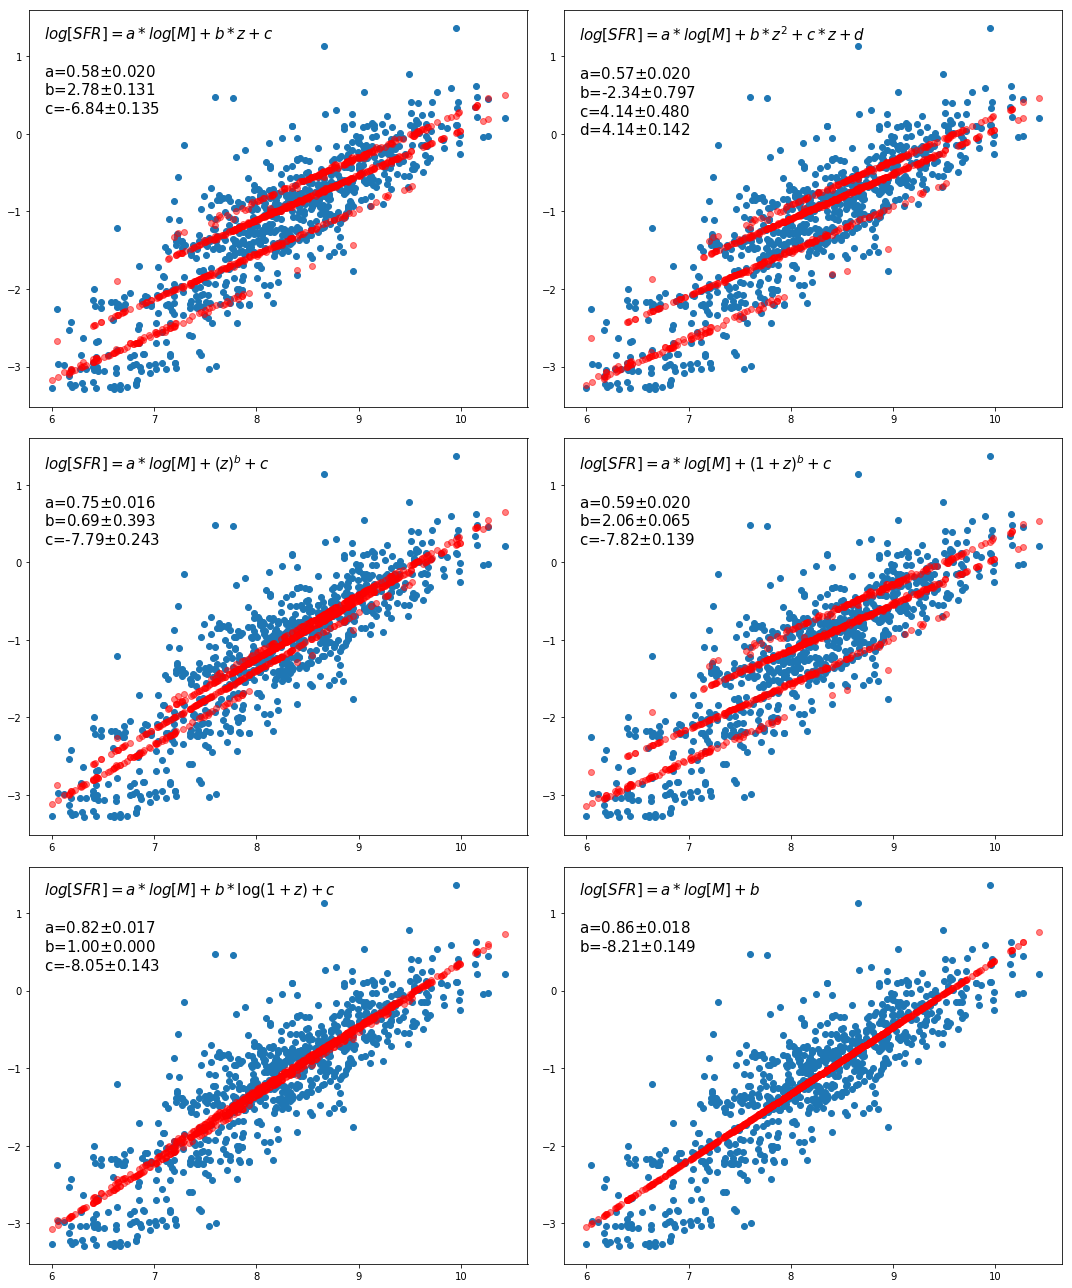

In [59]:
f, axes = plt.subplots(3,2)
axarr = np.ndarray.flatten(axes)

guess = (0.8,1, -7)
for ax, func, eqn_str in zip(axarr, [func0, func1, func2, func3, func4, line], 
                             [eqn0, eqn1, eqn2, eqn3, eqn4, eqn5]):
    ax.plot(smass0, sfrs00, 'o')
    print eqn_str
    
    if 'c' in eqn_str and 'd' not in eqn_str:   
        params, pcov = optimize.curve_fit(func, data00, sfrs00, guess, method='trf')
        perr = np.sqrt(np.diag(pcov))
        ax.plot(smass0, func(data00, *params), 'ro', alpha=0.5)
        ax.text(0.03,0.97,eqn_str+
            '\n\na='+'{:.2f}'.format(params[0])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[0])+
            '\nb='+'{:.2f}'.format(params[1])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[1])+
            '\nc='+'{:.2f}'.format(params[2])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[2]),
            transform=ax.transAxes,fontsize=15,ha='left',va='top')
    elif 'd' in eqn_str:
        params, pcov = optimize.curve_fit(func, data00, sfrs00, method='trf')
        perr = np.sqrt(np.diag(pcov))
        ax.plot(smass0, func(data00, *params), 'ro', alpha=0.5)
        ax.text(0.03,0.97,eqn_str+
            '\n\na='+'{:.2f}'.format(params[0])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[0])+
            '\nb='+'{:.2f}'.format(params[1])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[1])+
            '\nc='+'{:.2f}'.format(params[2])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[2])+
            '\nd='+'{:.2f}'.format(params[2])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[3]),
            transform=ax.transAxes,fontsize=15,ha='left',va='top')    
    else:
        params, pcov = optimize.curve_fit(func, smass0, sfrs00, method='trf')
        perr = np.sqrt(np.diag(pcov))
        ax.plot(smass0, func(smass0, *params), 'ro', alpha=0.5)
        ax.text(0.03,0.97,eqn_str+
            '\n\na='+'{:.2f}'.format(params[0])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[0])+
            '\nb='+'{:.2f}'.format(params[1])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[1]),
            transform=ax.transAxes,fontsize=15,ha='left',va='top')
    

f.set_size_inches(15,18)
f.tight_layout()

## method='dogbox'

$log[SFR] = a*log[M] + b*z + c$
$log[SFR] = a*log[M] + b*z^2 + c*z + d$
$log[SFR] = a*log[M] + (z)^{b} + c$
$log[SFR] = a*log[M] + (1+z)^{b} + c$
$log[SFR] = a*log[M] + b*\log(1+z) + c$
$log[SFR] = a*log[M] + b$


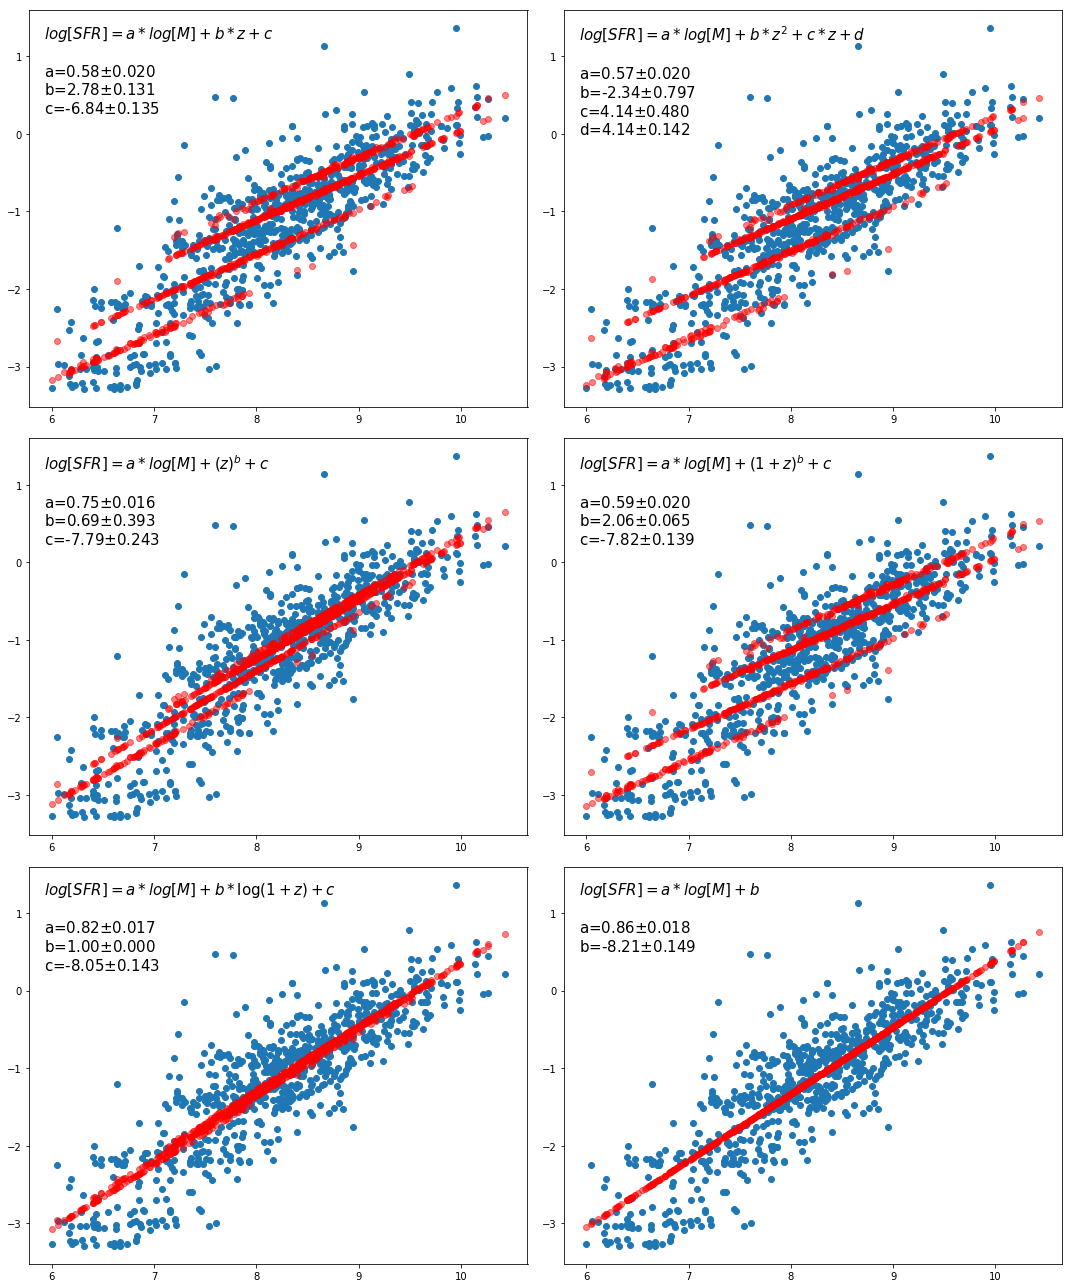

In [60]:
f, axes = plt.subplots(3,2)
axarr = np.ndarray.flatten(axes)

guess = (0.8,1, -7)
for ax, func, eqn_str in zip(axarr, [func0, func1, func2, func3, func4, line], 
                             [eqn0, eqn1, eqn2, eqn3, eqn4, eqn5]):
    ax.plot(smass0, sfrs00, 'o')
    print eqn_str
    
    if 'c' in eqn_str and 'd' not in eqn_str:   
        params, pcov = optimize.curve_fit(func, data00, sfrs00, guess, method='dogbox')
        perr = np.sqrt(np.diag(pcov))
        ax.plot(smass0, func(data00, *params), 'ro', alpha=0.5)
        ax.text(0.03,0.97,eqn_str+
            '\n\na='+'{:.2f}'.format(params[0])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[0])+
            '\nb='+'{:.2f}'.format(params[1])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[1])+
            '\nc='+'{:.2f}'.format(params[2])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[2]),
            transform=ax.transAxes,fontsize=15,ha='left',va='top')
    elif 'd' in eqn_str:
        params, pcov = optimize.curve_fit(func, data00, sfrs00, method='dogbox')
        perr = np.sqrt(np.diag(pcov))
        ax.plot(smass0, func(data00, *params), 'ro', alpha=0.5)
        ax.text(0.03,0.97,eqn_str+
            '\n\na='+'{:.2f}'.format(params[0])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[0])+
            '\nb='+'{:.2f}'.format(params[1])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[1])+
            '\nc='+'{:.2f}'.format(params[2])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[2])+
            '\nd='+'{:.2f}'.format(params[2])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[3]),
            transform=ax.transAxes,fontsize=15,ha='left',va='top')
    else:
        params, pcov = optimize.curve_fit(func, smass0, sfrs00, method='dogbox')
        perr = np.sqrt(np.diag(pcov))
        ax.plot(smass0, func(smass0, *params), 'ro', alpha=0.5)
        ax.text(0.03,0.97,eqn_str+
            '\n\na='+'{:.2f}'.format(params[0])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[0])+
            '\nb='+'{:.2f}'.format(params[1])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[1]),
            transform=ax.transAxes,fontsize=15,ha='left',va='top')
    

f.set_size_inches(15,18)
f.tight_layout()

# residuals

## 'lm'

$log[SFR] = a*log[M] + b*z + c$
$log[SFR] = a*log[M] + b*z^2 + c*z + d$
$log[SFR] = a*log[M] + (z)^{b} + c$
$log[SFR] = a*log[M] + (1+z)^{b} + c$
$log[SFR] = a*log[M] + b*\log(1+z) + c$
$log[SFR] = a*log[M] + b$


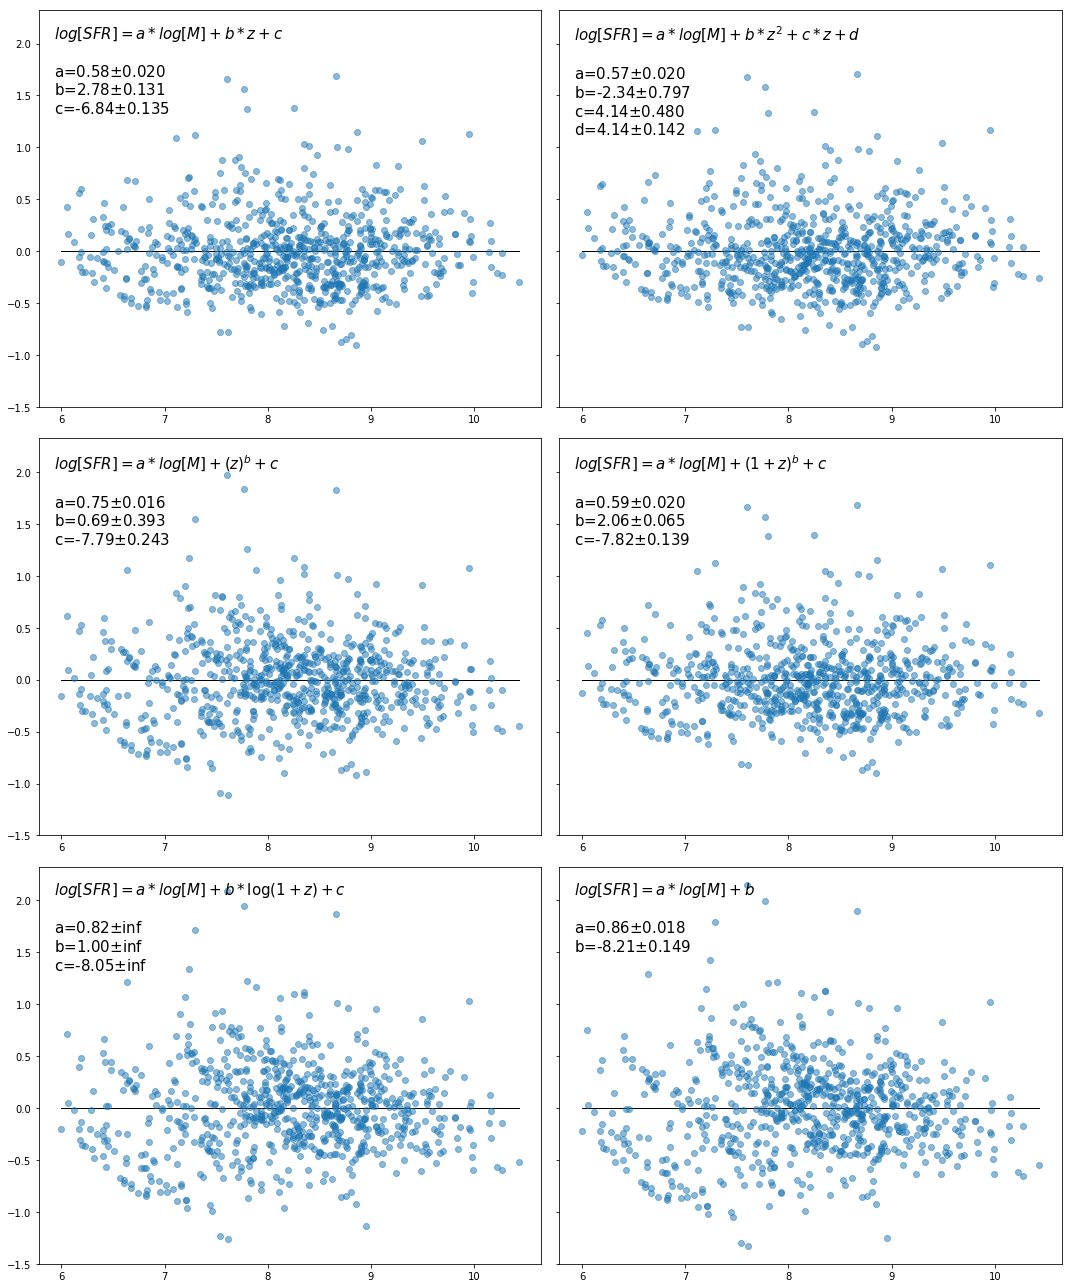

In [61]:
f, axes = plt.subplots(3,2, sharey=True)
axarr = np.ndarray.flatten(axes)

guess = (0.8,1, -7)
for ax, func, eqn_str in zip(axarr, [func0, func1, func2, func3, func4, line], 
                             [eqn0, eqn1, eqn2, eqn3, eqn4, eqn5]):
    print eqn_str
    ax.plot(smass0, np.zeros(len(smass0)), 'k-')
    
    if 'c' in eqn_str and 'd' not in eqn_str:   
        params, pcov = optimize.curve_fit(func, data00, sfrs00, guess, method='lm')
        perr = np.sqrt(np.diag(pcov))
        ax.plot(smass0, sfrs00 - func(data00, *params), 'o', alpha=0.5)
        ax.text(0.03,0.97,eqn_str+
            '\n\na='+'{:.2f}'.format(params[0])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[0])+
            '\nb='+'{:.2f}'.format(params[1])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[1])+
            '\nc='+'{:.2f}'.format(params[2])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[2]),
            transform=ax.transAxes,fontsize=15,ha='left',va='top')
    elif 'd' in eqn_str:
        params, pcov = optimize.curve_fit(func, data00, sfrs00, method='lm')
        perr = np.sqrt(np.diag(pcov))
        ax.plot(smass0, sfrs00 - func(data00, *params), 'o', alpha=0.5)
        ax.text(0.03,0.97,eqn_str+
            '\n\na='+'{:.2f}'.format(params[0])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[0])+
            '\nb='+'{:.2f}'.format(params[1])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[1])+
            '\nc='+'{:.2f}'.format(params[2])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[2])+
            '\nd='+'{:.2f}'.format(params[2])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[3]),
            transform=ax.transAxes,fontsize=15,ha='left',va='top')
    else:
        params, pcov = optimize.curve_fit(func, smass0, sfrs00, method='lm')
        perr = np.sqrt(np.diag(pcov))
        ax.plot(smass0, sfrs00 - func(smass0, *params), 'o', alpha=0.5)
        ax.text(0.03,0.97,eqn_str+
            '\n\na='+'{:.2f}'.format(params[0])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[0])+
            '\nb='+'{:.2f}'.format(params[1])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[1]),
            transform=ax.transAxes,fontsize=15,ha='left',va='top')
    

f.set_size_inches(15,18)
f.tight_layout()

## trf

$log[SFR] = a*log[M] + b*z + c$
$log[SFR] = a*log[M] + b*z^2 + c*z + d$
$log[SFR] = a*log[M] + (z)^{b} + c$
$log[SFR] = a*log[M] + (1+z)^{b} + c$
$log[SFR] = a*log[M] + b*\log(1+z) + c$
$log[SFR] = a*log[M] + b$


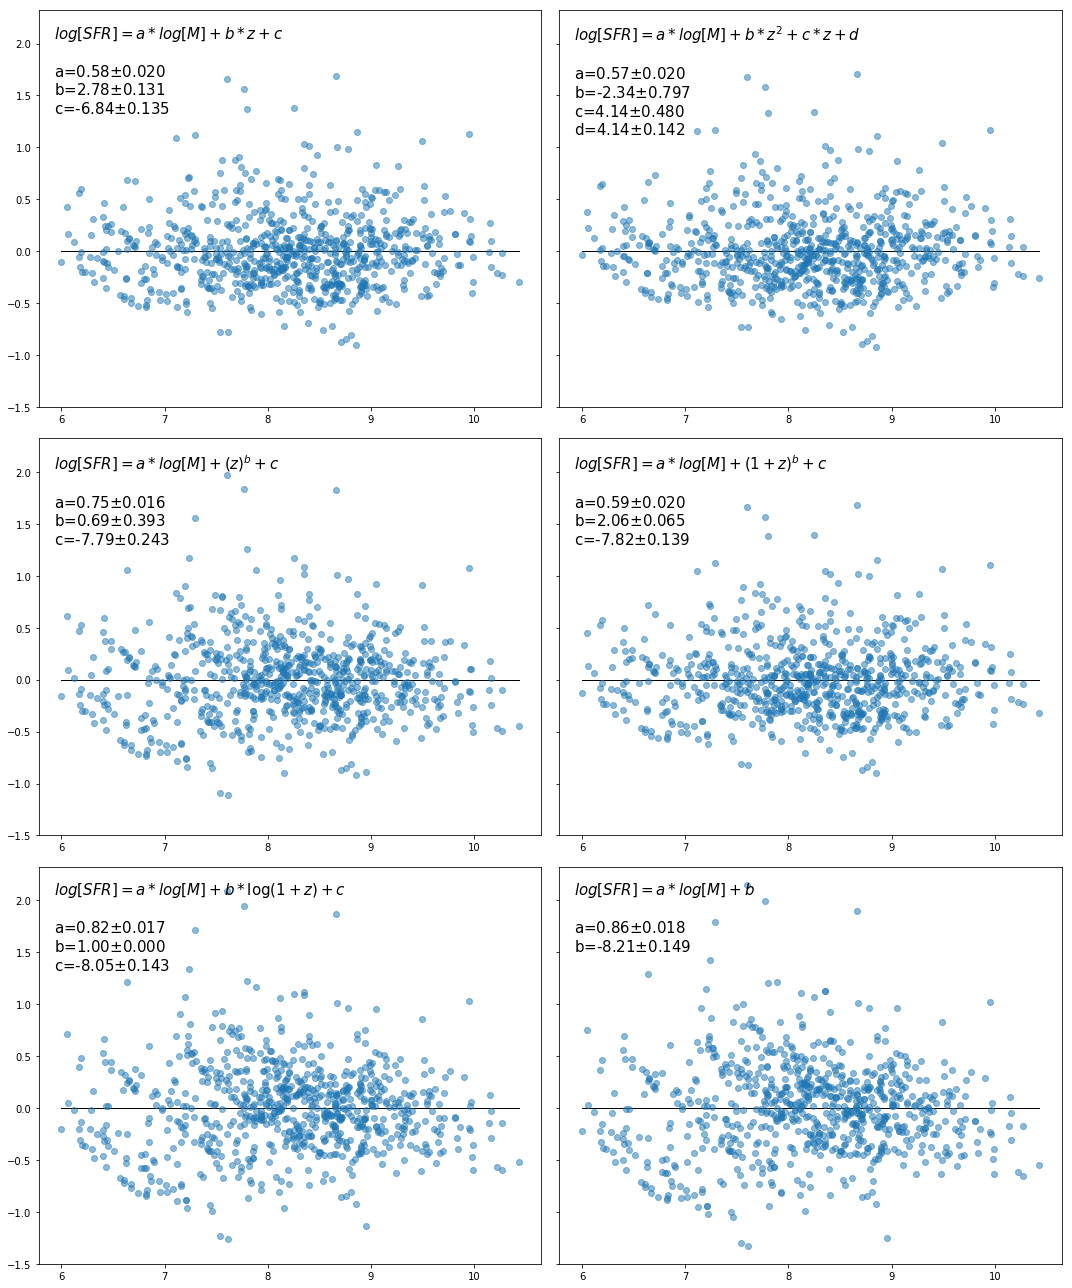

In [62]:
f, axes = plt.subplots(3,2, sharey=True)
axarr = np.ndarray.flatten(axes)

guess = (0.8,1, -7)
for ax, func, eqn_str in zip(axarr, [func0, func1, func2, func3, func4, line], 
                             [eqn0, eqn1, eqn2, eqn3, eqn4, eqn5]):
    print eqn_str
    ax.plot(smass0, np.zeros(len(smass0)), 'k-')
    
    if 'c' in eqn_str and 'd' not in eqn_str:   
        params, pcov = optimize.curve_fit(func, data00, sfrs00, guess, method='trf')
        perr = np.sqrt(np.diag(pcov))
        ax.plot(smass0, sfrs00 - func(data00, *params), 'o', alpha=0.5)
        ax.text(0.03,0.97,eqn_str+
            '\n\na='+'{:.2f}'.format(params[0])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[0])+
            '\nb='+'{:.2f}'.format(params[1])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[1])+
            '\nc='+'{:.2f}'.format(params[2])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[2]),
            transform=ax.transAxes,fontsize=15,ha='left',va='top')
    elif 'd' in eqn_str:
        params, pcov = optimize.curve_fit(func, data00, sfrs00, method='trf')
        perr = np.sqrt(np.diag(pcov))
        ax.plot(smass0, sfrs00 - func(data00, *params), 'o', alpha=0.5)
        ax.text(0.03,0.97,eqn_str+
            '\n\na='+'{:.2f}'.format(params[0])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[0])+
            '\nb='+'{:.2f}'.format(params[1])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[1])+
            '\nc='+'{:.2f}'.format(params[2])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[2])+
            '\nd='+'{:.2f}'.format(params[2])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[3]),
            transform=ax.transAxes,fontsize=15,ha='left',va='top')
    else:
        params, pcov = optimize.curve_fit(func, smass0, sfrs00, method='trf')
        perr = np.sqrt(np.diag(pcov))
        ax.plot(smass0, sfrs00 - func(smass0, *params), 'o', alpha=0.5)
        ax.text(0.03,0.97,eqn_str+
            '\n\na='+'{:.2f}'.format(params[0])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[0])+
            '\nb='+'{:.2f}'.format(params[1])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[1]),
            transform=ax.transAxes,fontsize=15,ha='left',va='top')
    

f.set_size_inches(15,18)
f.tight_layout()

# rms

## trf

$log[SFR] = a*log[M] + b*z + c$
bin dispersion: 5.0 | nan
bin dispersion: 6.0 | nan
bin dispersion: 7.0 | 0.295020467187
bin dispersion: 8.0 | 0.386049005032
bin dispersion: 9.0 | 0.352457174638
bin dispersion: 10.0 | 0.313185740494
$log[SFR] = a*log[M] + b*z^2 + c*z + d$
bin dispersion: 5.0 | nan
bin dispersion: 6.0 | nan
bin dispersion: 7.0 | 0.276853495737
bin dispersion: 8.0 | 0.390391535416
bin dispersion: 9.0 | 0.350410317042
bin dispersion: 10.0 | 0.306040265232
$log[SFR] = a*log[M] + (z)^{b} + c$


//anaconda/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
//anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
//anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
//anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
//anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


bin dispersion: 5.0 | nan
bin dispersion: 6.0 | nan
bin dispersion: 7.0 | 0.383244927294
bin dispersion: 8.0 | 0.466120419548
bin dispersion: 9.0 | 0.358560699696
bin dispersion: 10.0 | 0.299994497773
$log[SFR] = a*log[M] + (1+z)^{b} + c$
bin dispersion: 5.0 | nan
bin dispersion: 6.0 | nan
bin dispersion: 7.0 | 0.310027139348
bin dispersion: 8.0 | 0.387209783886
bin dispersion: 9.0 | 0.353071646148
bin dispersion: 10.0 | 0.315690129494
$log[SFR] = a*log[M] + b*\log(1+z) + c$
bin dispersion: 5.0 | nan
bin dispersion: 6.0 | nan
bin dispersion: 7.0 | 0.437254486188
bin dispersion: 8.0 | 0.520242439121
bin dispersion: 9.0 | 0.376132226052
bin dispersion: 10.0 | 0.307815231538
$log[SFR] = a*log[M] + b$
bin dispersion: 5.0 | nan
bin dispersion: 6.0 | nan
bin dispersion: 7.0 | 0.462054319563
bin dispersion: 8.0 | 0.548873089507
bin dispersion: 9.0 | 0.387387885838
bin dispersion: 10.0 | 0.313911628675


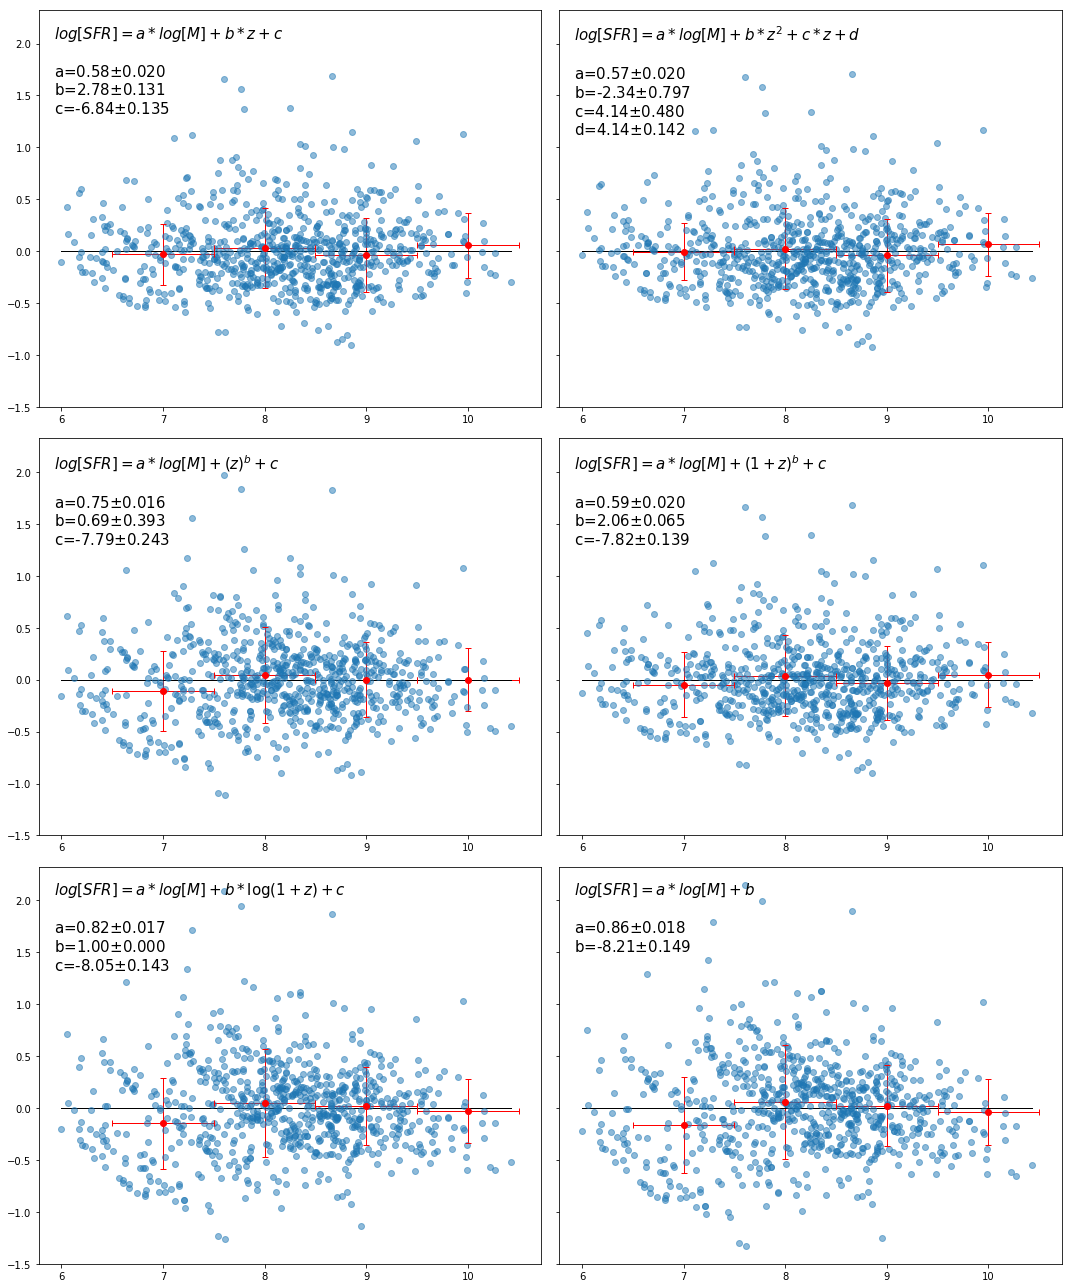

In [63]:
# min(smass0), max(smass0)
mbins0 = np.arange(4.5,11.5,1)
mbins = (mbins0+0.5)[:-1]
bin_ii = np.digitize(smass0, mbins)
# bin_ii

f, axes = plt.subplots(3,2, sharey=True)
axarr = np.ndarray.flatten(axes)

guess = (0.8,1, -7)
for ax, func, eqn_str in zip(axarr, [func0, func1, func2, func3, func4, line], 
                             [eqn0, eqn1, eqn2, eqn3, eqn4, eqn5]):
    print eqn_str
    ax.plot(smass0, np.zeros(len(smass0)), 'k-')
    
    sfrs_plot = np.array([])
    if 'c' in eqn_str and 'd' not in eqn_str:   
        params, pcov = optimize.curve_fit(func, data00, sfrs00, guess, method='trf')
        perr = np.sqrt(np.diag(pcov))
        sfrs_plot = sfrs00 - func(data00, *params)
        ax.text(0.03,0.97,eqn_str+
            '\n\na='+'{:.2f}'.format(params[0])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[0])+
            '\nb='+'{:.2f}'.format(params[1])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[1])+
            '\nc='+'{:.2f}'.format(params[2])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[2]),
            transform=ax.transAxes,fontsize=15,ha='left',va='top')
    elif 'd' in eqn_str:
        params, pcov = optimize.curve_fit(func, data00, sfrs00, method='trf')
        perr = np.sqrt(np.diag(pcov))
        sfrs_plot = sfrs00 - func(data00, *params)
        ax.text(0.03,0.97,eqn_str+
            '\n\na='+'{:.2f}'.format(params[0])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[0])+
            '\nb='+'{:.2f}'.format(params[1])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[1])+
            '\nc='+'{:.2f}'.format(params[2])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[2])+
            '\nd='+'{:.2f}'.format(params[2])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[3]),
            transform=ax.transAxes,fontsize=15,ha='left',va='top')
    else: # no redshift dependence
        params, pcov = optimize.curve_fit(func, smass0, sfrs00, method='trf')
        perr = np.sqrt(np.diag(pcov))
        sfrs_plot = sfrs00 - func(smass0, *params)
        ax.text(0.03,0.97,eqn_str+
            '\n\na='+'{:.2f}'.format(params[0])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[0])+
            '\nb='+'{:.2f}'.format(params[1])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[1]),
            transform=ax.transAxes,fontsize=15,ha='left',va='top')
        
    ax.plot(smass0, sfrs_plot, 'o', alpha=0.5)
    
    for i in range(6):
        bin_match = np.where(bin_ii == i)[0]
#         print np.mean(sfrs_plot[bin_match])
        ax.plot(mbins[i], np.mean(sfrs_plot[bin_match]), 'ro')
        ax.errorbar(mbins[i], np.mean(sfrs_plot[bin_match]), xerr=0.5, yerr=np.std(sfrs_plot[bin_match]),
                    capsize=3, color='red')
        print 'bin dispersion:', mbins[i], '|', np.std(sfrs_plot[bin_match])

f.set_size_inches(15,18)
f.tight_layout()

### color coding by filter

In [64]:
filts99 = filts[good_sig_iis]
cwheel = [np.array(mpl.rcParams['axes.prop_cycle'])[x]['color'] for x in range(4)]

In [65]:
# min(smass0), max(smass0)
mbins0 = np.arange(4.5,11.5,1)
mbins = (mbins0+0.5)[:-1]
bin_ii = np.digitize(smass0, mbins)
# bin_ii


f, axes = plt.subplots(3,2, sharey=True)
axarr = np.ndarray.flatten(axes)

guess = (0.8,1, -7)
for ax, func, eqn_str in zip(axarr, [func0, func1, func2, func3, func4, line], 
                             [eqn0, eqn1, eqn2, eqn3, eqn4, eqn5]):
    print eqn_str
    ax.plot(smass0, np.zeros(len(smass0)), 'k-')
    
    sfrs_plot = np.array([])
    if 'c' in eqn_str and 'd' not in eqn_str:   
        params, pcov = optimize.curve_fit(func, data00, sfrs00, guess, method='trf')
        perr = np.sqrt(np.diag(pcov))
        sfrs_plot = sfrs00 - func(data00, *params)
        ax.text(0.03,0.97,eqn_str+
            '\n\na='+'{:.2f}'.format(params[0])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[0])+
            '\nb='+'{:.2f}'.format(params[1])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[1])+
            '\nc='+'{:.2f}'.format(params[2])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[2]),
            transform=ax.transAxes,fontsize=15,ha='left',va='top')
    elif 'd' in eqn_str:
        params, pcov = optimize.curve_fit(func, data00, sfrs00, method='trf')
        perr = np.sqrt(np.diag(pcov))
        sfrs_plot = sfrs00 - func(data00, *params)
        ax.text(0.03,0.97,eqn_str+
            '\n\na='+'{:.2f}'.format(params[0])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[0])+
            '\nb='+'{:.2f}'.format(params[1])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[1])+
            '\nc='+'{:.2f}'.format(params[2])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[2])+
            '\nd='+'{:.2f}'.format(params[2])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[3]),
            transform=ax.transAxes,fontsize=15,ha='left',va='top')
    else: # no redshift dependence
        params, pcov = optimize.curve_fit(func, smass0, sfrs00, method='trf')
        perr = np.sqrt(np.diag(pcov))
        sfrs_plot = sfrs00 - func(smass0, *params)
        ax.text(0.03,0.97,eqn_str+
            '\n\na='+'{:.2f}'.format(params[0])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[0])+
            '\nb='+'{:.2f}'.format(params[1])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[1]),
            transform=ax.transAxes,fontsize=15,ha='left',va='top')
        
#     ax.plot(smass0, sfrs_plot, 'o', alpha=0.5)
    for ff,cc,ll in zip(['NB7', 'NB816', 'NB921', 'NB973'], cwheel, ['NB704,NB711', 'NB816', 'NB921', 'NB973']):
        filt_match = np.array([x for x in range(len(filts99)) if ff in filts99[x]])
        ax.plot(smass0[filt_match], sfrs_plot[filt_match], 'o', color=cc, alpha=0.3, label=ll)

#     plt.xlabel('M')
#     plt.ylabel('sigma_rms')
#     plt.legend(loc='best')
    
    for i in range(6):
        bin_match = np.where(bin_ii == i)[0]
#         print np.mean(sfrs_plot[bin_match])
        ax.plot(mbins[i], np.mean(sfrs_plot[bin_match]), 'ko')
        ax.errorbar(mbins[i], np.mean(sfrs_plot[bin_match]), xerr=0.5, yerr=np.std(sfrs_plot[bin_match]),
                    capsize=3, color='k')
        ax.annotate(r'$\sigma=$'+str(np.round(np.std(sfrs_plot[bin_match]), 4)), 
                    (mbins[i], np.mean(sfrs_plot[bin_match])-0.2), 
                    va='bottom', ha='center', fontsize=12, color='k', fontweight='bold')
#         print 'bin dispersion:', mbins[i], '|', np.std(sfrs_plot[bin_match])

f.set_size_inches(15,18)
f.tight_layout()

$log[SFR] = a*log[M] + b*z + c$
$log[SFR] = a*log[M] + b*z^2 + c*z + d$
$log[SFR] = a*log[M] + (z)^{b} + c$
$log[SFR] = a*log[M] + (1+z)^{b} + c$
$log[SFR] = a*log[M] + b*\log(1+z) + c$
$log[SFR] = a*log[M] + b$


ValueError: cannot convert float NaN to integer

<Figure size 1080x1296 with 6 Axes>

### using integer edge bins

In [66]:
# min(smass0), max(smass0)
mbins0 = np.arange(5.0,11.0,1.0)
mbins = (mbins0+0.5)[:-1]
bin_ii = np.digitize(smass0, mbins)
# bin_ii


f, axes = plt.subplots(3,2, sharey=True)
axarr = np.ndarray.flatten(axes)

guess = (0.8,1, -7)
for ax, func, eqn_str in zip(axarr, [func0, func1, func2, func3, func4, line], 
                             [eqn0, eqn1, eqn2, eqn3, eqn4, eqn5]):
    print eqn_str
    ax.plot(smass0, np.zeros(len(smass0)), 'k-')
    
    sfrs_plot = np.array([])
    if 'c' in eqn_str and 'd' not in eqn_str:   
        params, pcov = optimize.curve_fit(func, data00, sfrs00, guess, method='trf')
        perr = np.sqrt(np.diag(pcov))
        sfrs_plot = sfrs00 - func(data00, *params)
        ax.text(0.03,0.97,eqn_str+
            '\n\na='+'{:.2f}'.format(params[0])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[0])+
            '\nb='+'{:.2f}'.format(params[1])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[1])+
            '\nc='+'{:.2f}'.format(params[2])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[2]),
            transform=ax.transAxes,fontsize=15,ha='left',va='top')
    elif 'd' in eqn_str:
        params, pcov = optimize.curve_fit(func, data00, sfrs00, method='trf')
        perr = np.sqrt(np.diag(pcov))
        sfrs_plot = sfrs00 - func(data00, *params)
        ax.text(0.03,0.97,eqn_str+
            '\n\na='+'{:.2f}'.format(params[0])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[0])+
            '\nb='+'{:.2f}'.format(params[1])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[1])+
            '\nc='+'{:.2f}'.format(params[2])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[2])+
            '\nd='+'{:.2f}'.format(params[2])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[3]),
            transform=ax.transAxes,fontsize=15,ha='left',va='top')
    else: # no redshift dependence
        params, pcov = optimize.curve_fit(func, smass0, sfrs00, method='trf')
        perr = np.sqrt(np.diag(pcov))
        sfrs_plot = sfrs00 - func(smass0, *params)
        ax.text(0.03,0.97,eqn_str+
            '\n\na='+'{:.2f}'.format(params[0])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[0])+
            '\nb='+'{:.2f}'.format(params[1])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[1]),
            transform=ax.transAxes,fontsize=15,ha='left',va='top')
        
#     ax.plot(smass0, sfrs_plot, 'o', alpha=0.5)
    for ff,cc,ll in zip(['NB7', 'NB816', 'NB921', 'NB973'], cwheel, ['NB704,NB711', 'NB816', 'NB921', 'NB973']):
        filt_match = np.array([x for x in range(len(filts99)) if ff in filts99[x]])
        ax.plot(smass0[filt_match], sfrs_plot[filt_match], 'o', color=cc, alpha=0.3, label=ll)

#     plt.xlabel('M')
#     plt.ylabel('sigma_rms')
#     plt.legend(loc='best')
    
    for i in range(5):
        bin_match = np.where(bin_ii == i)[0]
#         print np.mean(sfrs_plot[bin_match])
        ax.plot(mbins[i], np.mean(sfrs_plot[bin_match]), 'ko')
        ax.errorbar(mbins[i], np.mean(sfrs_plot[bin_match]), xerr=0.5, yerr=np.std(sfrs_plot[bin_match]),
                    capsize=3, color='k')
        ax.annotate(r'$\sigma=$'+str(np.round(np.std(sfrs_plot[bin_match]), 4)), 
                    (mbins[i], np.mean(sfrs_plot[bin_match])-0.2), 
                    va='bottom', ha='center', fontsize=12, color='k', fontweight='bold')
#         print 'bin dispersion:', mbins[i], '|', np.std(sfrs_plot[bin_match])

f.set_size_inches(15,18)
f.tight_layout()

$log[SFR] = a*log[M] + b*z + c$
$log[SFR] = a*log[M] + b*z^2 + c*z + d$
$log[SFR] = a*log[M] + (z)^{b} + c$
$log[SFR] = a*log[M] + (1+z)^{b} + c$
$log[SFR] = a*log[M] + b*\log(1+z) + c$
$log[SFR] = a*log[M] + b$


ValueError: cannot convert float NaN to integer

<Figure size 1080x1296 with 6 Axes>

### using quintile bins

$log[SFR] = a*log[M] + b*z + c$
sigma= 0.3214 	0.396 	0.3366 	0.3706 	0.3089 	
===
$log[SFR] = a*log[M] + b*z^2 + c*z + d$
sigma= 0.3123 	0.4019 	0.3369 	0.3681 	0.302 	
===
$log[SFR] = a*log[M] + (z)^{b} + c$
sigma= 0.4323 	0.4518 	0.3558 	0.3577 	0.308 	
===
$log[SFR] = a*log[M] + (1+z)^{b} + c$
sigma= 0.3327 	0.3947 	0.3364 	0.3708 	0.3118 	
===
$log[SFR] = a*log[M] + b*\log(1+z) + c$
sigma= 0.497 	0.4955 	0.3775 	0.3657 	0.3224 	
===
$log[SFR] = a*log[M] + b$
sigma= 0.5281 	0.5199 	0.3908 	0.3722 	0.3317 	
===
mean mass: 6.9 ('6.0', '7.44')
mean mass: 7.767 ('7.45', '8.03')
mean mass: 8.249 ('8.04', '8.46')
mean mass: 8.714 ('8.47', '8.94')
mean mass: 9.39 ('8.95', '10.43')


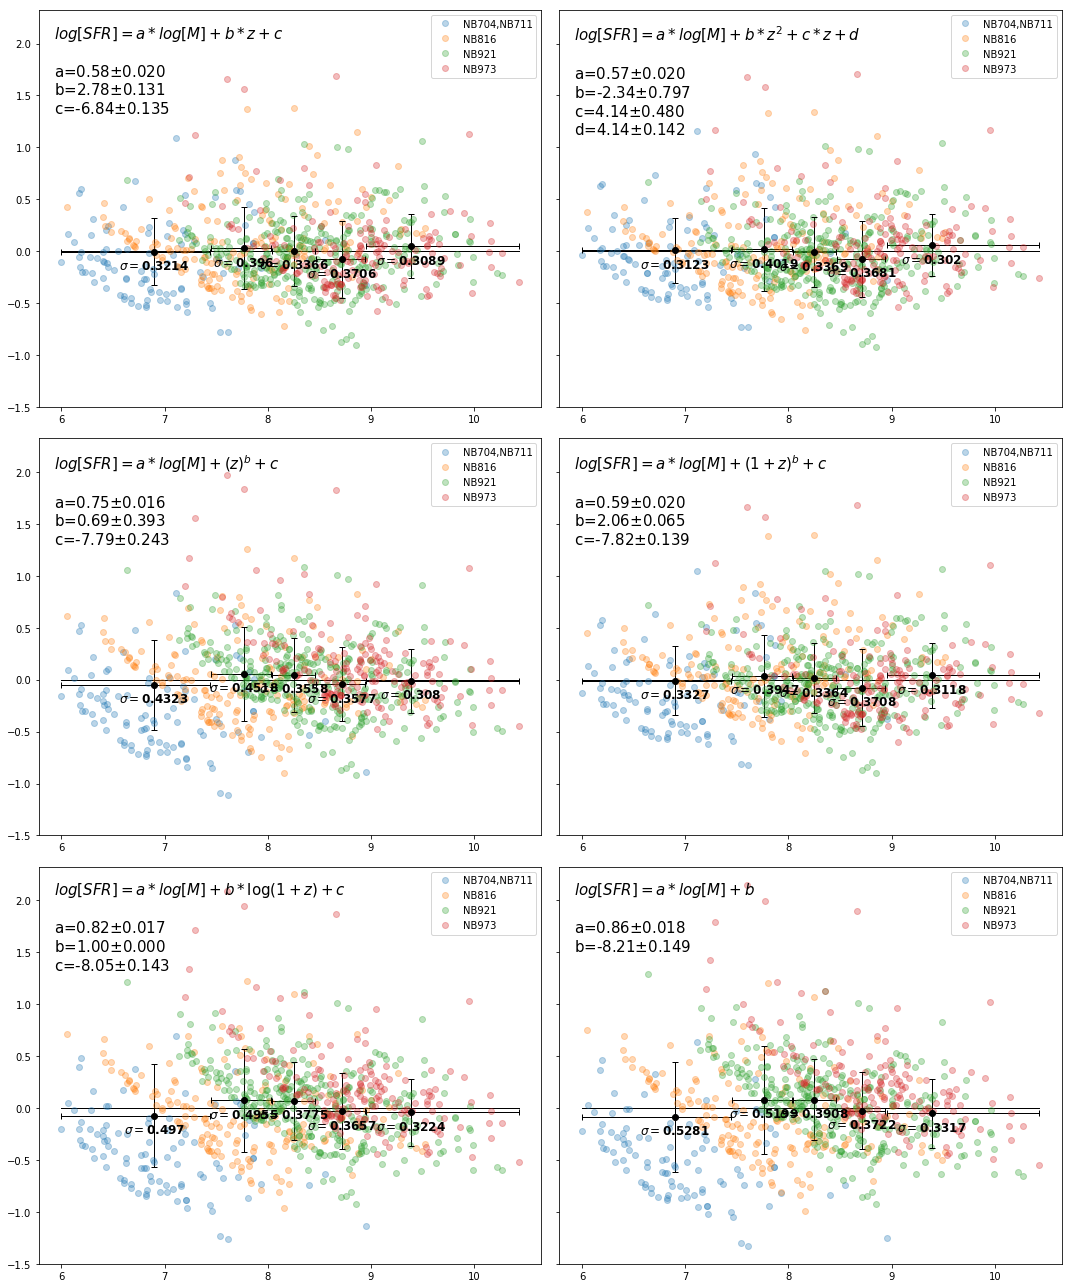

In [67]:
# quintile bins
perc20 = np.percentile(smass0, 20)
index_0 = np.array([x for x in range(len(smass0)) if (smass0[x]>0 and smass0[x]<=perc20)])

perc40 = np.percentile(smass0, 40)
index_1 = np.array([x for x in range(len(smass0)) if (smass0[x]>perc20 and smass0[x]<=perc40)])

perc60 = np.percentile(smass0, 60)
index_2 = np.array([x for x in range(len(smass0)) if (smass0[x]>perc40 and smass0[x]<=perc60)])

perc80 = np.percentile(smass0, 80)
index_3 = np.array([x for x in range(len(smass0)) if (smass0[x]>perc60 and smass0[x]<=perc80)])

perc100 = np.percentile(smass0, 100)
index_4 = np.array([x for x in range(len(smass0)) if (smass0[x]>perc80 and smass0[x]<=perc100)])


f, axes = plt.subplots(3,2, sharey=True)
axarr = np.ndarray.flatten(axes)

guess = (0.8,1, -7)
for ax, func, eqn_str in zip(axarr, [func0, func1, func2, func3, func4, line], 
                             [eqn0, eqn1, eqn2, eqn3, eqn4, eqn5]):
    print eqn_str
    ax.plot(smass0, np.zeros(len(smass0)), 'k-')
    
    # fitting models and labeling subplots
    sfrs_plot = np.array([])
    if 'c' in eqn_str and 'd' not in eqn_str:   
        params, pcov = optimize.curve_fit(func, data00, sfrs00, guess, method='trf')
        perr = np.sqrt(np.diag(pcov))
        sfrs_plot = sfrs00 - func(data00, *params)
        ax.text(0.03,0.97,eqn_str+
            '\n\na='+'{:.2f}'.format(params[0])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[0])+
            '\nb='+'{:.2f}'.format(params[1])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[1])+
            '\nc='+'{:.2f}'.format(params[2])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[2]),
            transform=ax.transAxes,fontsize=15,ha='left',va='top')
    elif 'd' in eqn_str:
        params, pcov = optimize.curve_fit(func, data00, sfrs00, method='trf')
        perr = np.sqrt(np.diag(pcov))
        sfrs_plot = sfrs00 - func(data00, *params)
        ax.text(0.03,0.97,eqn_str+
            '\n\na='+'{:.2f}'.format(params[0])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[0])+
            '\nb='+'{:.2f}'.format(params[1])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[1])+
            '\nc='+'{:.2f}'.format(params[2])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[2])+
            '\nd='+'{:.2f}'.format(params[2])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[3]),
            transform=ax.transAxes,fontsize=15,ha='left',va='top')
    else: # no redshift dependence
        params, pcov = optimize.curve_fit(func, smass0, sfrs00, method='trf')
        perr = np.sqrt(np.diag(pcov))
        sfrs_plot = sfrs00 - func(smass0, *params)
        ax.text(0.03,0.97,eqn_str+
            '\n\na='+'{:.2f}'.format(params[0])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[0])+
            '\nb='+'{:.2f}'.format(params[1])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[1]),
            transform=ax.transAxes,fontsize=15,ha='left',va='top')

    # plotting data, color-coded by filter
    for ff,cc,ll in zip(['NB7', 'NB816', 'NB921', 'NB973'], cwheel, ['NB704,NB711', 'NB816', 'NB921', 'NB973']):
        filt_match = np.array([x for x in range(len(filts99)) if ff in filts99[x]])
        ax.plot(smass0[filt_match], sfrs_plot[filt_match], 'o', color=cc, alpha=0.3, label=ll)
#     if ax==axarr[0]:
    ax.legend(loc='best')


    # getting residuals (annotated) for binned data
    print 'sigma=',
    for bin_match in [index_0,index_1,index_2,index_3,index_4]:
        mbin = np.mean(smass0[bin_match])
        sfrbin = np.mean(sfrs_plot[bin_match])
        
        ax.plot(mbin, sfrbin, 'ko')
        xerr00=np.reshape([mbin - min(smass0[bin_match]), 
                           max(smass0[bin_match]) - mbin], (2,1))
        ax.errorbar(mbin, sfrbin, 
                    xerr=xerr00, yerr=np.std(sfrs_plot[bin_match]),
                    capsize=3, color='k')
        ax.annotate(#r'$\mu=$'+str(np.round(np.mean(smass0[bin_match]), 4))+'\n'+
                    r'$\sigma=$'+str(np.round(np.std(sfrs_plot[bin_match]), 4)), 
                    (mbin, sfrbin-0.2), va='bottom', ha='center', fontsize=12, color='k', fontweight='bold')
        print str(np.round(np.std(sfrs_plot[bin_match]), 4)), '\t',

    print '\n==='
        
for bin_match in [index_0,index_1,index_2,index_3,index_4]:
    print 'mean mass:', str(np.round(np.mean(smass0[bin_match]), 3)), (str(np.round(min(smass0[bin_match]),3)), str(np.round(max(smass0[bin_match]),3)))

f.set_size_inches(15,18)
f.tight_layout()

In [68]:
# ^^^


### doing a linear regr. fit with the $\beta$ coeff fixed

In [69]:
ssfr = sfrs00-smass0

In [70]:
aa = np.where(zspec0 < 0.15)[0]
bb = np.where((zspec0 > 0.2) & (zspec0 < 0.3))[0]
cc = np.where((zspec0 > 0.3) & (zspec0 <= 0.45))[0]
dd = np.where(zspec0 > 0.45)[0]
# np.mean(ssfr[aa])
# np.mean(ssfr[dd])

In [71]:
# offseta = np.mean(ssfr[aa]) - zspec0[-1]
# offsetd = np.mean(ssfr[dd]) - np.mean(zspec0[dd])
# offsetd
# (y = 0 would refer to no evolution)

In [72]:
def line(x, m, b):
    return m*x + b

tempxarr0 = np.array([np.mean(zspec0[aa]), np.mean(zspec0[bb]), np.mean(zspec0[cc]), np.mean(zspec0[dd])])
tempyarr0 = np.array([np.mean(ssfr[aa]), np.mean(ssfr[bb]), np.mean(ssfr[cc]), np.mean(ssfr[dd])])
tempparams, temppcov = optimize.curve_fit(line, tempxarr0, tempyarr0)

tempparams

array([ 0.97164851, -9.6860826 ])

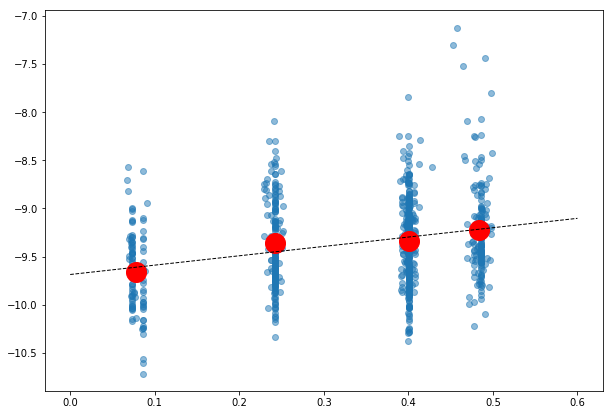

In [73]:
# f, ax = plt.subplots(1,2)
plt.plot(zspec0, ssfr, 'o', alpha=0.5)
plt.plot(np.mean(zspec0[aa]), np.mean(ssfr[aa]),'ro', ms=20)
plt.plot(np.mean(zspec0[bb]), np.mean(ssfr[bb]),'ro', ms=20)
plt.plot(np.mean(zspec0[cc]), np.mean(ssfr[cc]),'ro', ms=20)
plt.plot(np.mean(zspec0[dd]), np.mean(ssfr[dd]),'ro', ms=20)


plt.plot(np.arange(0,0.7,0.1),  line(np.arange(0,0.7,0.1), *tempparams), 'k--')

plt.gcf().set_size_inches(10,7)

In [75]:
print np.mean(ssfr[aa]), np.mean(ssfr[bb]), np.mean(ssfr[cc]), np.mean(ssfr[dd])

-9.65622998366 -9.3621477117 -9.33378950254 -9.22279607735


In [80]:
tempeqn0 = r'$log[SFR] = \alpha*log[M] + \beta*z + \gamma$'
def tempfunc0(data, a, c):
#     b=0.52472598956890604
    b=tempparams[0]
    return a*data[:,0] + b*data[:,1] + c
    
tempguess0 = (0.5, -7)
tempparams0, temppcov0 = optimize.curve_fit(tempfunc0, data00, sfrs00)

In [81]:
tempparams0

array([ 0.76080461, -7.72804164])

In [82]:
# errs
np.sqrt(np.diag(temppcov0))

array([ 0.01604203,  0.13224446])

sigma= 0.4455 	0.4553 	0.3558 	0.3571 	0.309 	
===


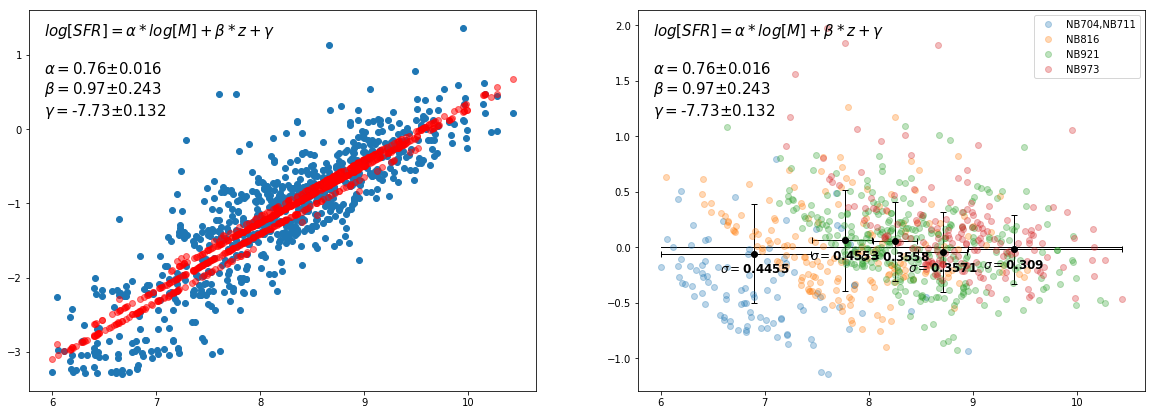

In [83]:
f, axarr = plt.subplots(1,2)
ax = axarr[0]
ax.plot(smass0, sfrs00, 'o')
ax.plot(smass0, tempfunc0(data00, *tempparams0), 'ro', alpha=0.5)
ax.text(0.03,0.97,tempeqn0+
            '\n\n'+r'$\alpha=$'+'{:.2f}'.format(tempparams0[0])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(temppcov0))[0])+
            '\n'+r'$\beta=$'+'{:.2f}'.format(tempparams[0])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(temppcov))[0])+
            '\n'+r'$\gamma=$'+'{:.2f}'.format(tempparams0[1])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(temppcov0))[1]),
        transform=ax.transAxes,fontsize=15,ha='left',va='top')
 
    
    
ax = axarr[1]
# residuals
# quintile bins
perc20 = np.percentile(smass0, 20)
index_0 = np.array([x for x in range(len(smass0)) if (smass0[x]>0 and smass0[x]<=perc20)])

perc40 = np.percentile(smass0, 40)
index_1 = np.array([x for x in range(len(smass0)) if (smass0[x]>perc20 and smass0[x]<=perc40)])

perc60 = np.percentile(smass0, 60)
index_2 = np.array([x for x in range(len(smass0)) if (smass0[x]>perc40 and smass0[x]<=perc60)])

perc80 = np.percentile(smass0, 80)
index_3 = np.array([x for x in range(len(smass0)) if (smass0[x]>perc60 and smass0[x]<=perc80)])

perc100 = np.percentile(smass0, 100)
index_4 = np.array([x for x in range(len(smass0)) if (smass0[x]>perc80 and smass0[x]<=perc100)])


ax.plot(smass0, np.zeros(len(smass0)), 'k-')

# fitting models and labeling subplots
sfrs_plot = np.array([])
tempparams0, temppcov0 = optimize.curve_fit(tempfunc0, data00, sfrs00)
tempperr0 = np.sqrt(np.diag(temppcov0))
sfrs_plot = sfrs00 - tempfunc0(data00, *tempparams0)
ax.text(0.03,0.97,tempeqn0+
        '\n\n'+r'$\alpha=$'+'{:.2f}'.format(tempparams0[0])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(temppcov0))[0])+
        '\n'+r'$\beta=$'+'{:.2f}'.format(tempparams[0])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(temppcov))[0])+
        '\n'+r'$\gamma=$'+'{:.2f}'.format(tempparams0[1])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(temppcov0))[1]),
        transform=ax.transAxes,fontsize=15,ha='left',va='top')
    
# plotting data, color-coded by filter
for ff,cc,ll in zip(['NB7', 'NB816', 'NB921', 'NB973'], cwheel, ['NB704,NB711', 'NB816', 'NB921', 'NB973']):
    filt_match = np.array([x for x in range(len(filts99)) if ff in filts99[x]])
    ax.plot(smass0[filt_match], sfrs_plot[filt_match], 'o', color=cc, alpha=0.3, label=ll)

ax.legend(loc='best')


# getting residuals (annotated) for binned data
print 'sigma=',
for bin_match in [index_0,index_1,index_2,index_3,index_4]:
    mbin = np.mean(smass0[bin_match])
    sfrbin = np.mean(sfrs_plot[bin_match])

    ax.plot(mbin, sfrbin, 'ko')
    xerr00=np.reshape([mbin - min(smass0[bin_match]), 
                       max(smass0[bin_match]) - mbin], (2,1))
    ax.errorbar(mbin, sfrbin, 
                xerr=xerr00, yerr=np.std(sfrs_plot[bin_match]),
                capsize=3, color='k')
    ax.annotate(#r'$\mu=$'+str(np.round(np.mean(smass0[bin_match]), 4))+'\n'+
                r'$\sigma=$'+str(np.round(np.std(sfrs_plot[bin_match]), 4)), 
                (mbin, sfrbin-0.2), va='bottom', ha='center', fontsize=12, color='k', fontweight='bold')
    print str(np.round(np.std(sfrs_plot[bin_match]), 4)), '\t',

print '\n==='


f.set_size_inches(20,7)


### doing PCA with w/ sklearn?

In [86]:
from astropy.table import Table
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd

In [87]:
features = ['log(M)', 'z']
df = pd.DataFrame(data00, columns=features)
df['log(sfr)'] = sfrs00
# df

In [88]:
ttab0 = Table(np.array(df), names=['log(M)', 'z', 'log(sfr)'])
asc.write(ttab0, 'temp_zdependence.txt')

In [89]:
# Separating out the features
x = df.loc[:, features].values
# Separating out the target
y = df.loc[:,['log(sfr)']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

In [90]:
# The original data has 2 columns (log(M), z).
# In this section, the code projects the original data which is 2 dimensional into 1 dimension. 
# After dimensionality reduction, there usually isn’t a particular meaning assigned to each principal component. 
# The new component is just the main dimension of variation

pca = PCA(n_components=1)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, 
                           columns = ['principal component 1'])
# principalDf

In [91]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pca = PCA(n_components=2)
cls = LogisticRegression() 

pipe = Pipeline([('pca', pca), ('logistic', cls)])
pipe.fit(features_train, df_train["target"])
predictions = pipe.predict(features_valid)

NameError: name 'features_train' is not defined

### extrapolating functional form from Iyer+18 and overlaying on our sample

In [92]:
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
cosmo.age(0).value

def iyer18(log_m, z):
    '''cosmo.age(z).value is t_univ  is the age of the universe in Gyr'''
    return (0.8 - 0.017*cosmo.age(z).value)*log_m - (6.487 - 0.039*cosmo.age(z).value)

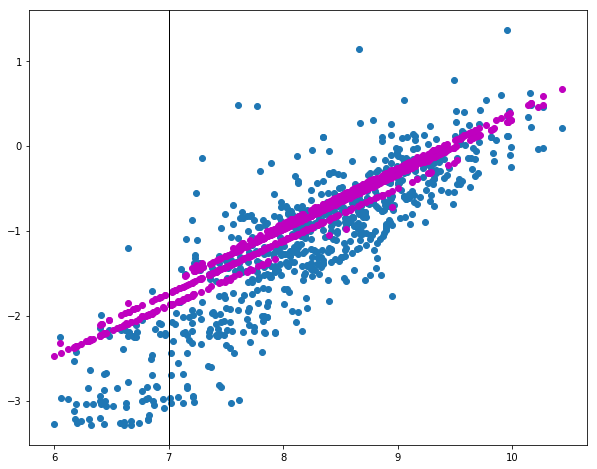

In [93]:
plt.plot(smass0, sfrs00, 'o')
plt.plot(smass0, iyer18(smass0, zspec0), 'mo')
plt.axvline(7, color='black')
plt.gcf().set_size_inches(10,8)

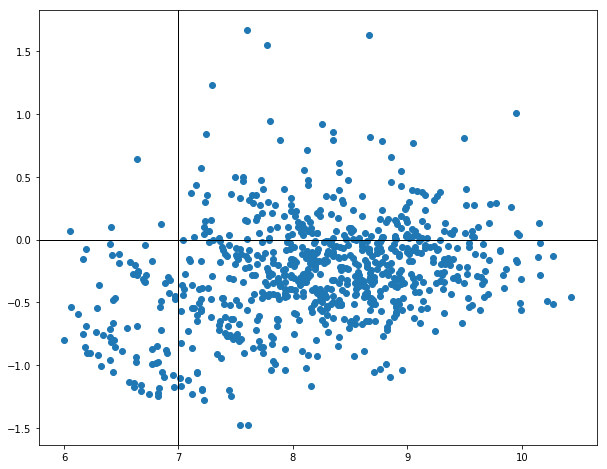

In [94]:
# resids plot w/ the iyer functional form
plt.plot(smass0, sfrs00 - iyer18(smass0, zspec0), 'o')
plt.axvline(7, color='black')
plt.axhline(0, color='black')
plt.gcf().set_size_inches(10,8)